In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import bokeh
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from bokeh.io import output_notebook, curdoc, reset_output
from bokeh.plotting import figure, output_file, show, ColumnDataSource, save
output_notebook() 

Loading BokehJS ...

In [101]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
result_dir = os.path.join(os.path.dirname(os.getcwd()), 'results')
thumbnail_dir = os.path.join(data_dir, 'thumbnail')

if not os.path.exists(thumbnail_dir):
    os.makedirs(thumbnail_dir)

In [102]:
hayao_pics = pd.read_csv(os.path.join(data_dir, 'hayao_pics.csv'))
disney_pics = pd.read_csv(os.path.join(data_dir, 'disney_pics.csv'))

In [103]:
hayao_thumbnail_dir = os.path.join(thumbnail_dir, 'hayao_thumbnail')
if not os.path.exists(hayao_thumbnail_dir):
    os.makedirs(hayao_thumbnail_dir)
    
disney_thumbnail_dir = os.path.join(thumbnail_dir, 'disney_thumbnail')
if not os.path.exists(disney_thumbnail_dir):
    os.makedirs(disney_thumbnail_dir)

In [104]:
def make_thumbnail(image_name, image_path, thumbnail_dir, size):
    image = Image.open(image_path)
    image.thumbnail(size)
    thumbnail_path = os.path.join(thumbnail_dir, image_name + '_thumbnail.jpg')
    image.save(thumbnail_path)

In [105]:
size = (128, 128)
hayao_image_dir = os.path.join(data_dir, 'images/images_hayao')
disney_image_dir = os.path.join(data_dir, 'images/images_disney')

In [106]:
for img in os.listdir(hayao_image_dir):
    if img.endswith('.jpg'):
        img_path = os.path.join(hayao_image_dir, img)
        img_name = os.path.splitext(img)[0]
        make_thumbnail(img_name, img_path, hayao_thumbnail_dir, size)
    
for img in os.listdir(disney_image_dir):
    if img.endswith('.jpg'):
        img_path = os.path.join(disney_image_dir, img)
        img_name = os.path.splitext(img)[0]
        make_thumbnail(img_name, img_path, disney_thumbnail_dir, size)

In [107]:
hayao_pics.head()

,Unnamed: 0,name,width,height,mean_hue,mean_saturation,mean_value,mean_entropy,edge_sum
0,0,0,67,98,0.281277,0.530815,0.231668,3.895495,0.583236
1,1,1,99,99,0.273528,0.405424,0.722306,4.257138,0.662596
2,2,100,147,100,0.600145,0.325997,0.711840,3.021263,0.270850
3,3,101,147,100,0.507668,0.685993,0.552678,3.737993,0.201171
4,4,102,147,100,0.154216,0.728086,0.574216,4.672342,0.498490


In [108]:
disney_pics.head()

,Unnamed: 0,name,width,height,mean_hue,mean_saturation,mean_value,mean_entropy,edge_sum
0,0,0,67,98,0.272307,0.148943,0.831144,3.778824,0.819642
1,1,1,99,99,0.346913,0.500670,0.275656,4.424552,0.585586
2,2,10,99,99,0.453854,0.168975,0.484728,4.181699,0.481131
3,3,100,99,99,0.351184,0.669260,0.497502,4.214874,0.554411
4,4,101,99,99,0.136235,0.926444,0.331088,3.405405,0.365691


In [109]:
def make_bitmap(name, df, feature1, feature2, thumbnail_dir, size, color, result_dir):
    figure = Image.new('RGB', (size, size), color)
    i = 0
    for i in range(df.shape[0]):
        thumbnail_path = os.path.join(thumbnail_dir, str(df['name'].iloc[i]) + '_thumbnail.jpg')
        thumbnail = Image.open(thumbnail_path)
        coordinates = int(df[feature1].iloc[i] * size), int(df[feature2].iloc[i] * size)
        figure.paste(thumbnail, coordinates)
    figure_path = os.path.join(result_dir, '{} {} vs. {}.jpg'.format(name, feature1, feature2))
    figure.save(figure_path)
    
    image = plt.imread(figure_path)
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.imshow(image)
    ax.axis('off')
    ax.set_title('{} {} vs. {}'.format(name, feature1, feature2))   

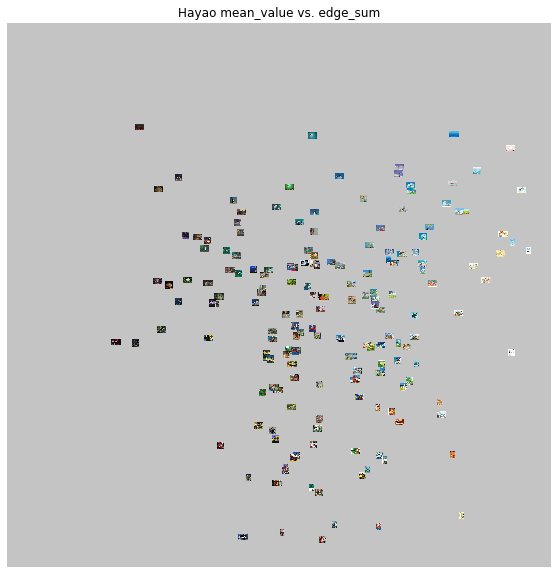

In [110]:
make_bitmap('Hayao', hayao_pics, 'mean_value', 'edge_sum', hayao_thumbnail_dir, 7500, (196, 196, 196), result_dir)

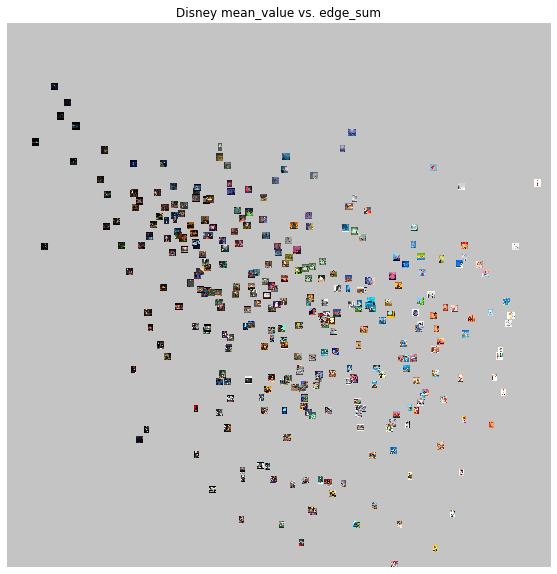

In [111]:
make_bitmap('Disney', disney_pics, 'mean_value', 'edge_sum', disney_thumbnail_dir, 7500, (196, 196, 196), result_dir)

In [153]:
def make_interactive(feature1, feature2, width, height):
    hayao_img_lst = ['https://raw.githubusercontent.com/ucsd-dsc-arts/dsc160-midterm-group9/master/data/images/images_hayao/' 
                + str(img_name) + '.jpg' for img_name in hayao_pics['name']] 
    disney_img_lst = ['https://raw.githubusercontent.com/ucsd-dsc-arts/dsc160-midterm-group9/master/data/images/images_disney/' 
                + str(img_name) + '.jpg' for img_name in disney_pics['name']] 
    hayao_source = ColumnDataSource(data = dict(
        x = list(hayao_pics[feature1]),
        y = list(hayao_pics[feature2]),
        img = hayao_img_lst,
        studios = ['Hayao'] * hayao_pics.shape[0]
    ))
    disney_source = ColumnDataSource(data = dict(
        x = list(disney_pics[feature1]),
        y = list(disney_pics[feature2]),
        img = disney_img_lst,
        studios = ['Disney'] * disney_pics.shape[0]
    ))
    

    TOOLTIPS = """
        <div>
            <div>
                <img
                    src="@img" height="128" alt="@img" width="128"
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
            </div>
            <div>
                <span style="font-size: 15px; font-weight: bold;">@studios</span>
            </div>
            <div>
                <span style="font-size: 10px;">(@x, @y)</span>
            </div>
        </div>
    """

    p = figure(plot_width = width, plot_height = height, tooltips = TOOLTIPS, 
               title = '{} vs. {}'.format(feature1, feature2), x_axis_label = feature1, y_axis_label = feature2)

    p.circle('x', 'y', size = 10, source = hayao_source, color = 'red', legend_label = 'Hayao')
    p.circle('x', 'y', size = 10, source = disney_source, color = 'blue', legend_label = 'Disney')
    
    output_file(os.path.join(result_dir, '{} vs. {}.html'.format(feature1, feature2)))
    save(p)    

In [154]:
make_interactive('mean_saturation', 'edge_sum', 800, 600)

In [ ]:
hayao_plot = 
hayao_plot_keywords = 
hayao_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(hayao_plot_keywords) 
                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(hayao_wordcloud) 
plt.axis("off") 
plt.title('Hayao Movie Plot Keywords')
plt.show() 

In [ ]:
disney_plot = 
disney_plot_keywords = 
disney_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(disney_plot_keywords) 
                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(disney_wordcloud) 
plt.axis("off") 
plt.title('Disney Movie Plot Keywords')
plt.show() 